Switch to GPU

In [ ]:
#Installs for NVIDIA GeForce RTX 3080
#pip install transformers
#pip install scikit-learn
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#separately download cuda_12.3.1_546.12_windows & follow express install instructions

import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Print the name of the GPU
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

Hugging Face implementation of 10.34133/research.0004 by jonghyunlee/ChemBERT_ChEMBL_pretrained

Tyrosine Kinase Dataset: https://www.kaggle.com/datasets/ricardoromeroochoa/tyrosine-kinases-ligands-with-bioactivity-data

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Define a dataset class
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, scaler=None):
        self.encodings = encodings
        self.labels_original = labels.copy()

        # Standardize the target values if a scaler is provided
        if scaler:
            self.labels_standardized = scaler.fit_transform(self.labels_original.reshape(-1, 1)).flatten()
        else:
            self.labels_standardized = self.labels_original

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels_standardized[idx]], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels_original)

# Load the ChemBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("jonghyunlee/ChemBERT_ChEMBL_pretrained")
model = AutoModelForSequenceClassification.from_pretrained("jonghyunlee/ChemBERT_ChEMBL_pretrained", num_labels=1)

# Load data from excel spreadsheet
df = pd.read_csv("D:/Projects/KaggleDatasets/Kinase_data.csv")

# Extract SMILES strings and pIC50 values
X = df['canonical_smiles'].tolist()
y = df['pIC50'].values

# Split the data into training and testing sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Tokenize and encode the data
max_length = 128
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)

# Initialize the scaler
scaler = StandardScaler()

# Convert tokenized data into a torch Dataset
train_dataset = TorchDataset(train_encodings, y_train, scaler=scaler)
valid_dataset = TorchDataset(valid_encodings, y_test, scaler=scaler)

# Define metrics for evaluating regression task
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

Train/Test Model

In [ ]:
# Specifiy the arguments for the trainer  
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 10,     
    per_device_train_batch_size = 128,   
    per_device_eval_batch_size = 128,   
    weight_decay = 0.01,               
    learning_rate = 0.0001,
    logging_dir = './logs',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'eval_r2',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = train_dataset,         
    eval_dataset = valid_dataset,          
    compute_metrics = compute_metrics_for_regression,     
)

# Train the model
trainer.train()

In [6]:
# Call the summary
trainer.evaluate()

  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3602725565433502,
 'eval_mse': 0.36027252674102783,
 'eval_rmse': 0.6002270579338074,
 'eval_mae': 0.4509042799472809,
 'eval_r2': 0.6397274699911657,
 'eval_smape': 76.6716819188622,
 'eval_runtime': 1.2276,
 'eval_samples_per_second': 3493.9,
 'eval_steps_per_second': 27.697,
 'epoch': 10.0}

Compare Predictions vs. Ground Truth

  0%|          | 0/34 [00:00<?, ?it/s]

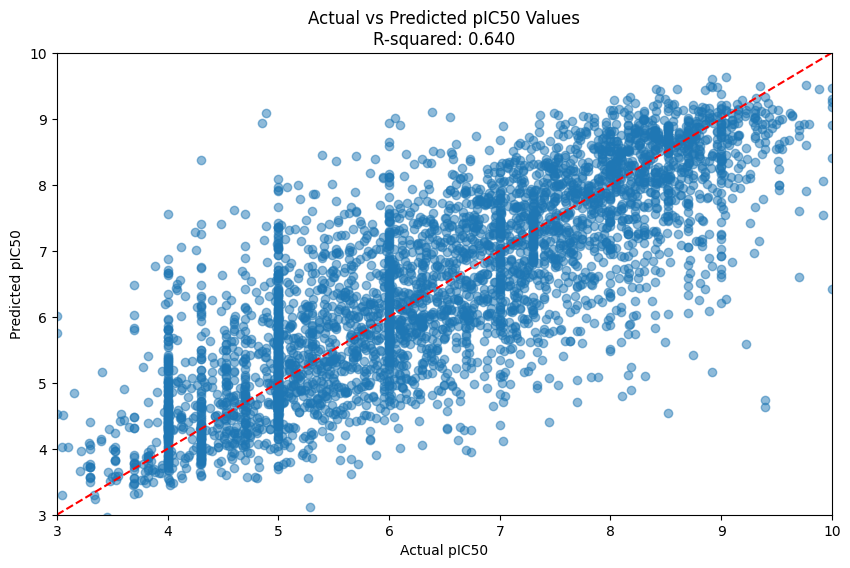

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Get predictions on the validation dataset
predictions_standardized = trainer.predict(valid_dataset).predictions.flatten()

# Inverse transform the standardized predictions to get the original scale
predictions_original = scaler.inverse_transform(predictions_standardized.reshape(-1, 1)).flatten()

# Get R-squared value
r2 = r2_score(y_test, predictions_original)

# Plotting the predicted values against actual values
minrange = 3
maxrange = 10
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_original, alpha=0.5)
plt.plot([minrange, maxrange], [minrange, maxrange], color='red', linestyle='--')  # Identity line
plt.title(f'Actual vs Predicted pIC50 Values\nR-squared: {r2:.3f}')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.xlim([minrange, maxrange])
plt.ylim([minrange, maxrange])
plt.show()